In [1]:
import math
import cmath
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

In [2]:
# database preparation for machine learning input

def create_column_name(frequencies):
    
    # create column name for pandas database input
    
    nf = len(frequencies)
    col_Ra_name = ['Ra']*nf
    col_P_name = ['P']*nf

    for ii in range(nf):
        # column name for apparent resistivity
        col_Ra_name[ii] = col_Ra_name[ii]+ str(ii+1)

        # column name for phase
        col_P_name[ii] = col_P_name[ii]+ str(ii+1)
    
    return col_Ra_name, col_P_name



In [3]:
# Forward model code
# modified from https://www.digitalearthlab.com/tutorial/tutorial-1d-mt-forward/

mu = 4*math.pi*1E-7; #Magnetic Permeability (H/m)
def mt1d(frequencies,resistivities,thicknesses):

    n = len(resistivities);
    
    nf = len(frequencies)
    appres = np.zeros(nf)
    phases = np.zeros(nf)
    ii = 0
    
    for frequency in frequencies:   
        w =  2*math.pi*frequency;       
        impedances = list(range(n));
        #compute basement impedance
        impedances[n-1] = cmath.sqrt(w*mu*resistivities[n-1]*1j);



        for j in range(n-2,-1,-1):
            resistivity = resistivities[j];
            thickness = thicknesses[j];

            # 3. Compute apparent resistivity from top layer impedance
            #Step 2. Iterate from bottom layer to top(not the basement) 
            # Step 2.1 Calculate the intrinsic impedance of current layer
            dj = cmath.sqrt((w * mu * (1.0/resistivity))*1j);
            wj = dj * resistivity;
            # Step 2.2 Calculate Exponential factor from intrinsic impedance
            ej = cmath.exp(-2*thickness*dj);                     

            # Step 2.3 Calculate reflection coeficient using current layer
            #          intrinsic impedance and the below layer impedance
            belowImpedance = impedances[j + 1];
            rj = (wj - belowImpedance)/(wj + belowImpedance);
            re = rj*ej; 
            Zj = wj * ((1 - re)/(1 + re));
            impedances[j] = Zj;    

        # Step 3. Compute apparent resistivity from top layer impedance
        Z = impedances[0];
        absZ = abs(Z);
        apparentResistivity = (absZ * absZ)/(mu * w);
        phase = math.atan2(Z.imag, Z.real)
#         print(frequency, '\t', apparentResistivity, '\t', phase);
        
        appres[ii] = apparentResistivity
        phases[ii] = phase
        
        
        ii = ii+1
        
        
        
    return appres,phases
    


In [4]:
# Create database for subsurface with 3 layers

nr = 3 # 3 layers
nd = 2 # 2 layer thicknesses, the bottom layer has infinite thickness


# define frequency range in logarithmic scale
frequencies = np.logspace(-4,4, num=20,base=10)
# frequencies = [0.0001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,10000];

nf = len(frequencies)


# random number limit (in log10) and size

# resistivity limit
low_limit_r = 0
high_limit_r = 3

# thickness limit
low_limit_d = 1
high_limit_d = np.log10(300)

# number of data
size = 1000

# define random resistivities with log-uniform distribution
R1s = 10**np.random.uniform(low_limit_r,high_limit_r,size)
R2s = 10**np.random.uniform(low_limit_r,high_limit_r,size)
R3s = 10**np.random.uniform(low_limit_r,high_limit_r,size)


# define random thicknesses with log-uniform distribution
d1s = 10**np.random.uniform(low_limit_d,high_limit_d,size)
d2s = 10**np.random.uniform(low_limit_d,high_limit_d,size)


# print(thickness_possible)


[col_Ra_name, col_P_name] = create_column_name(frequencies)



df = pd.DataFrame(columns=[['R1','R2','R3','d1','d2'] + col_Ra_name + col_P_name],
                  index=range(0, int(size)))

print(size, ' data will be generated')

start = time.time();


ii = 0


for R1,R2,R3,d1,d2 in zip(R1s,R2s,R3s,d1s,d2s):
    
    resistivities = [R1, R2, R3];
    thicknesses = [d1, d2];

    [appres,phases] =mt1d(frequencies,resistivities,thicknesses)

    # save into the database

    # log resistivities
    df.iloc[ii,0:nr] = np.log10(resistivities)

    # log layer thicknesses
    df.iloc[ii,nr:nr+nd] = np.log10(thicknesses)

    # log apparent resistivities
    df.iloc[ii,nr+nd:nr+nd+nf] = np.log10(appres)

    # phases
    df.iloc[ii,nr+nd+nf:nr+nd+nf+nf] = phases

    ii = ii+1


print('');
print('time taken = ', time.time() - start, 's');


1000  data will be generated

time taken =  2.3970019817352295 s


Text(0.5, 0, 'frequency')

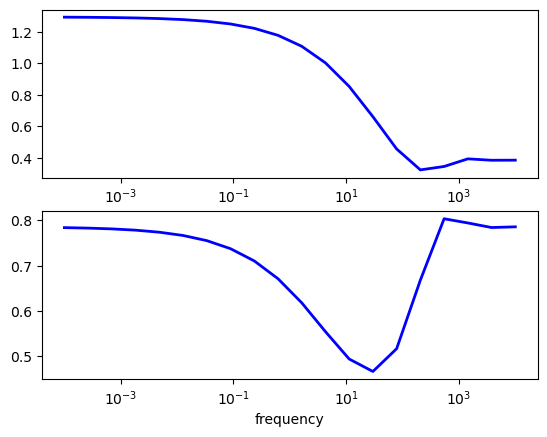

In [5]:
# plot random result

id_plot = random.randint(0,ii-1)

fig,ax = plt.subplots(2,1)

ax[0].plot(frequencies,df.iloc[id_plot,nr+nd:nr+nd+nf], color='blue', lw=2)
ax[1].plot(frequencies,df.iloc[id_plot,nr+nd+nf:nr+nd+nf+nf], color='blue', lw=2)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('frequency')

In [6]:
# save data to csv
df.to_csv('mt1d_training_random1k.csv',index=False)